## 필요 모듈 불러오기

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw

### Dataset download

In [2]:
# 다운로드에 매우 긴 시간이 소요됩니다. 
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

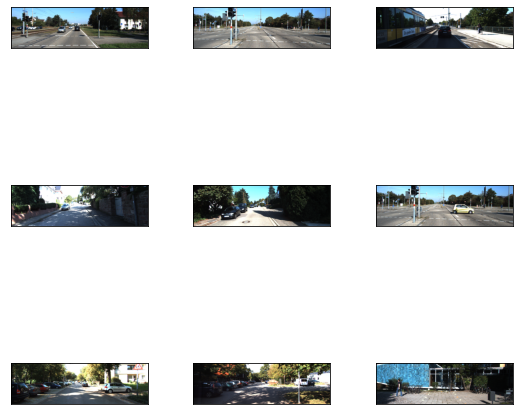

In [5]:
fig = tfds.show_examples(ds_train, ds_info)

In [6]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/home/aiffel/tensorflow_datasets/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
         

In [7]:
TakeDataset = ds_train.take(1)

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([-1.42, -1.08,  2.05], dtype=float32)>, 'bbox': <tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0.48684493, 0.46631664, 0.54419786, 0.49243134],
       [0.4390107 , 0.39300483, 0.5371925 , 0.45189014],
       [0.45713905, 0.2655735 , 0.54676473, 0.32101777]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1.43, 1.66, 4.15],
       [1.48, 1.56, 3.62],
       [1.68, 1.67, 4.29]], dtype=float32)>, 'location': <tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[ -0.5 ,   0.69,  50.49],
       [ -3.3 ,   1.13,  30.82],
       [-12.65,   1.07,  38.43]], dtype=float32)>, 'occluded': <tf.Tensor: shape=(3,), dtype=int64, numpy=array([0, 0, 1])>, 'rotation_y': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([-1.44, -1.19,  1.73], dtype=float32)>, 'truncated': <tf.Tensor: shape=(3,), dtype=float32, numpy

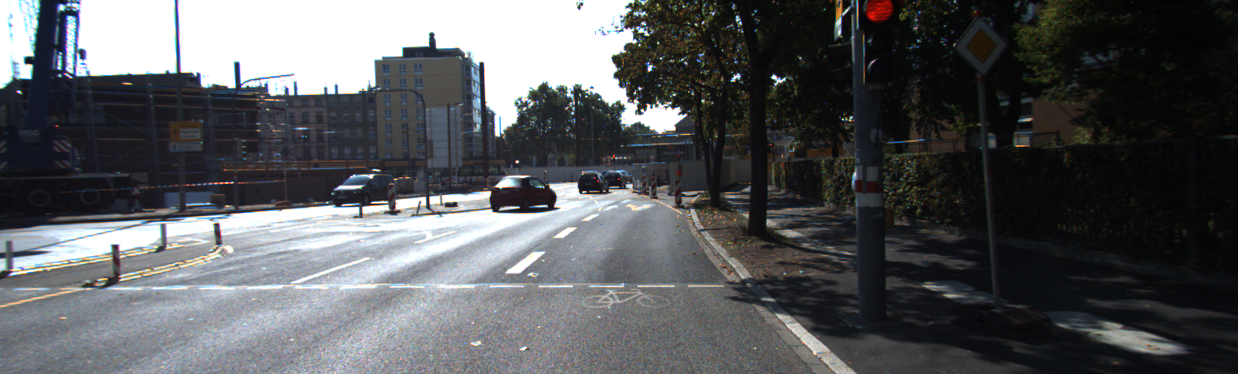

In [8]:
for example in TakeDataset:  
    print('------Example------')
    print(list(example.keys())) # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
img

width: 1242  height: 375
(3, 4)
[634.39    211.83    689.12994 152.73001]
[  0.   270.47 124.32 199.6 ]
[328.91 218.89 388.47 188.19]
<PIL.Image.Image image mode=RGB size=1242x375 at 0x7F25E0765110>


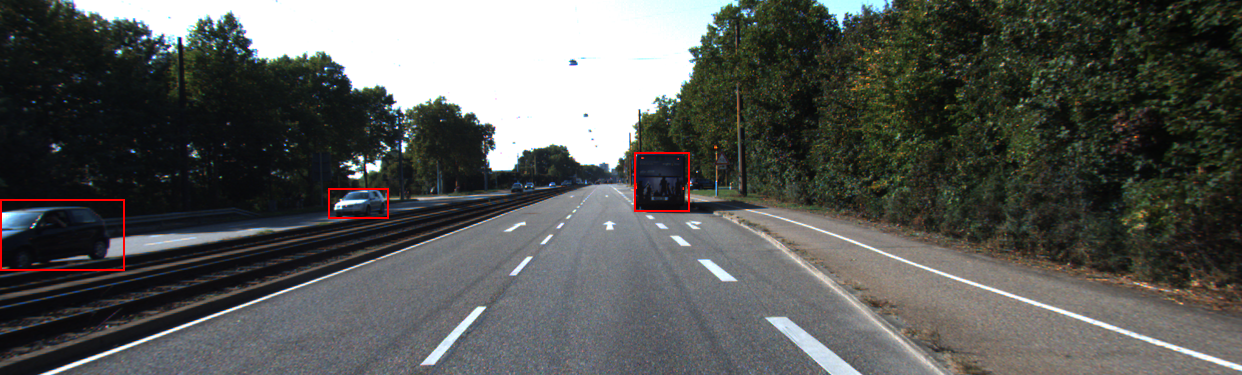

In [8]:
# 이미지 위에 바운딩 박스를 그려 화면에 표시해 주세요.
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    print('width:', width, ' height:', height)
    print(object_bbox.shape)
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height

    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        print(_rect)
        draw.rectangle(_rect, outline=(255,0,0), width=2)
    print(input_image)
    return input_image

visualize_bbox(img, objects['bbox'].numpy())

In [9]:
import os
data_dir = os.getenv('HOME')+'/aiffel/object_detection/data'
img_dir = os.getenv('HOME')+'/kitti_images'
train_csv_path = data_dir + '/kitti_train.csv'

# parse_dataset 함수를 구현해 주세요.
def parse_dataset(dataset, img_dir="kitti_images", total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)
    # Dataset의 claas를 확인하여 class에 따른 index를 확인해둡니다.
    # 저는 기존의 class를 차와 사람으로 나누었습니다.
    type_class_map = {
        0: "car",
        1: "car",
        2: "car",
        3: "person",
        4: "person",
        5: "person",
    }
    # Keras retinanet을 학습하기 위한 dataset을 csv로 parsing하기 위해서 필요한 column을 가진 pandas.DataFrame을 생성합니다.
    df = pd.DataFrame(columns=["img_path", "x1", "y1", "x2", "y2", "class_name"])
    for item in tqdm(dataset, total=total):
        filename = item['image/file_name'].numpy().decode('utf-8')
        img_path = os.path.join(img_dir, filename)

        img = Image.fromarray(item['image'].numpy())
        img.save(img_path)
        object_bbox = item['objects']['bbox']
        object_type = item['objects']['type'].numpy()
        width, height = img.size

        # tf.dataset의 bbox좌표가 0과 1사이로 normalize된 좌표이므로 이를 pixel좌표로 변환합니다.
        x_min = object_bbox[:,1] * width
        x_max = object_bbox[:,3] * width
        y_min = height - object_bbox[:,2] * height
        y_max = height - object_bbox[:,0] * height

        # 한 이미지에 있는 여러 Object들을 한 줄씩 pandas.DataFrame에 append합니다.
        rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                "img_path": img_path,
                "x1": _rect[0],
                "y1": _rect[1],
                "x2": _rect[2],
                "y2": _rect[3],
                "class_name": type_class_map[_type]
            }, ignore_index=True)
            break
    return df

df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
df_train.to_csv(train_csv_path, sep=',',index = False, header=False)

100%|██████████| 6347/6347 [12:24<00:00,  8.53it/s]


In [10]:
test_csv_path = data_dir + '/kitti_test.csv'

df_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)
df_test.to_csv(test_csv_path, sep=',',index = False, header=False)

100%|██████████| 711/711 [01:27<00:00,  8.09it/s]


In [11]:
class_txt_path = data_dir + '/classes.txt'

def save_class_format(path="./classes.txt"):
    class_type_map = {
        "car" : 0,
        "person": 1
    }
    with open(path, mode='w', encoding='utf-8') as f:
        for k, v in class_type_map.items():
            f.write(f"{k},{v}\n")

save_class_format(class_txt_path)

## 모델 학습

In [12]:
# RetinaNet 훈련이 시작됩니다!! 50epoch 훈련에 1시간 이상 소요될 수 있습니다. 
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 50 --steps 195 csv data/kitti_train.csv data/classes.txt

2021-04-27 15:51:20.081338: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-04-27 15:51:21.176615: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-04-27 15:51:21.180194: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-04-27 15:51:21.202571: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-04-27 15:51:21.203113: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.44GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2021-04-27 15:51:21.203130: I tensorflow/stream_executor/platform/default/ds

res2a_branch1 (Conv2D)          (None, None, None, 2 16384       pool1[0][0]                      
__________________________________________________________________________________________________
bn2a_branch2c (BatchNormalizati (None, None, None, 2 1024        res2a_branch2c[0][0]             
__________________________________________________________________________________________________
bn2a_branch1 (BatchNormalizatio (None, None, None, 2 1024        res2a_branch1[0][0]              
__________________________________________________________________________________________________
res2a (Add)                     (None, None, None, 2 0           bn2a_branch2c[0][0]              
                                                                 bn2a_branch1[0][0]               
__________________________________________________________________________________________________
res2a_relu (Activation)         (None, None, None, 2 0           res2a[0][0]                      
__________

2021-04-27 15:51:24.977620: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-04-27 15:51:24.978184: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2599990000 Hz
Epoch 1/50
2021-04-27 15:51:31.589000: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2021-04-27 15:51:33.179729: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2021-04-27 15:51:33.212192: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2021-04-27 15:51:33.484590: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-04-27 15:51:48.696870: W tensor

Epoch 18/50
195/195 [==============================] - 62s 317ms/step - loss: 1.4459 - regression_loss: 1.1016 - classification_loss: 0.3443

Epoch 00018: saving model to ./snapshots/resnet50_csv_18.h5

Epoch 00018: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
Epoch 19/50
195/195 [==============================] - 62s 317ms/step - loss: 1.2054 - regression_loss: 0.9156 - classification_loss: 0.2898

Epoch 00019: saving model to ./snapshots/resnet50_csv_19.h5
Epoch 20/50
195/195 [==============================] - 63s 320ms/step - loss: 1.0735 - regression_loss: 0.8259 - classification_loss: 0.2476

Epoch 00020: saving model to ./snapshots/resnet50_csv_20.h5
Epoch 21/50
195/195 [==============================] - 63s 320ms/step - loss: 1.0388 - regression_loss: 0.8052 - classification_loss: 0.2336

Epoch 00021: saving model to ./snapshots/resnet50_csv_21.h5
Epoch 22/50
195/195 [==============================] - 63s 320ms/step - loss: 1.0786 - regression_loss: 0.8256 

195/195 [==============================] - 63s 321ms/step - loss: 0.9364 - regression_loss: 0.7146 - classification_loss: 0.2217

Epoch 00039: saving model to ./snapshots/resnet50_csv_39.h5
Epoch 40/50
195/195 [==============================] - 65s 332ms/step - loss: 0.9593 - regression_loss: 0.7259 - classification_loss: 0.2334

Epoch 00040: saving model to ./snapshots/resnet50_csv_40.h5

Epoch 00040: ReduceLROnPlateau reducing learning rate to 9.999999717180686e-11.
Epoch 41/50
195/195 [==============================] - 66s 335ms/step - loss: 0.8936 - regression_loss: 0.6778 - classification_loss: 0.2159

Epoch 00041: saving model to ./snapshots/resnet50_csv_41.h5
Epoch 42/50
195/195 [==============================] - 63s 320ms/step - loss: 0.9786 - regression_loss: 0.7344 - classification_loss: 0.2442

Epoch 00042: saving model to ./snapshots/resnet50_csv_42.h5

Epoch 00042: ReduceLROnPlateau reducing learning rate to 9.99999943962493e-12.
Epoch 43/50
195/195 [======================

In [13]:
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/convert_model.py snapshots/resnet50_csv_50.h5 snapshots/resnet50_csv_50_infer.h5

2021-04-27 16:47:07.004672: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-04-27 16:47:08.559102: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-04-27 16:47:08.562807: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-04-27 16:47:08.590476: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-04-27 16:47:08.591014: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.44GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2021-04-27 16:47:08.591041: I tensorflow/stream_executor/platform/default/ds

## 시각화

In [32]:
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

gpu = '0'
setup_gpu(gpu)

dir_path = os.getenv('HOME') + '/aiffel/object_detection/'
model_path = os.path.join(dir_path, 'snapshots', 'resnet50_csv_50_infer.h5')
model = load_model(model_path, backbone_name='resnet50')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Physical devices cannot be modified after being initialized
1 Physical GPUs, 1 Logical GPUs


[593.62396 175.42699 625.3568  205.85602]
[198.40547 132.13652 358.19675 231.12091]


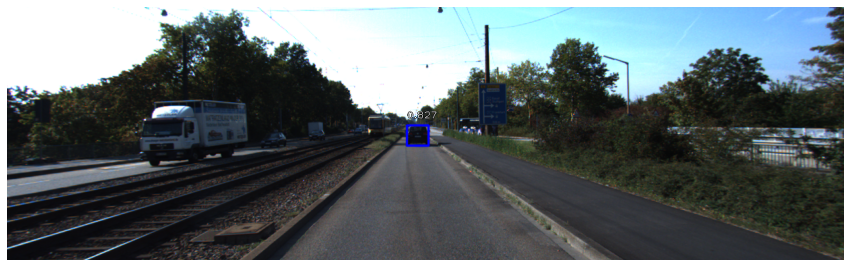

In [33]:
import os
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/go_1.png'

# inference_on_image 함수를 구현해 주세요.
def inference_on_image(model, img_path="./test_set/go_1.png", visualize=True):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    # display images
    if  visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score < 0.5:
                break
            b = box.astype(int)
            draw_box(draw, b, color=color_map[label])

            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)

        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()            


inference_on_image(model, img_path=img_path)

[770.43823 150.66943 843.90234 317.60114]
[770.48553 152.81769 847.8329  315.13553]


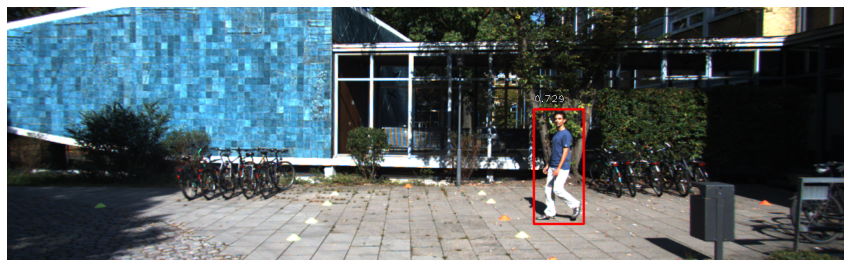

In [34]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'
inference_on_image(model, img_path=img_path)

## 자율주행 시스템 만들기

In [50]:
def self_drive_assist(img_path, size_limit=300):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    # display images

    answer = 'Go'
    
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        print(box)
        if score < 0.5:
            break
        b = box.astype(int)
        draw_box(draw, b, color=color_map[label])

        caption = "{:.3f}".format(score)
        draw_caption(draw, b, caption)

        if label == 1:
            answer = 'Stop'
        elif box[2] - box[0] >= 300 or box[3] - box[1] >= 300:
            answer = 'Stop'
    

    plt.figure(figsize=(15, 15))
    plt.axis('off')
    plt.imshow(draw)
    plt.show()
    
    return answer

## 자율주행 시스템 평가하기

[770.43823 150.66943 843.90234 317.60114]
[770.48553 152.81769 847.8329  315.13553]


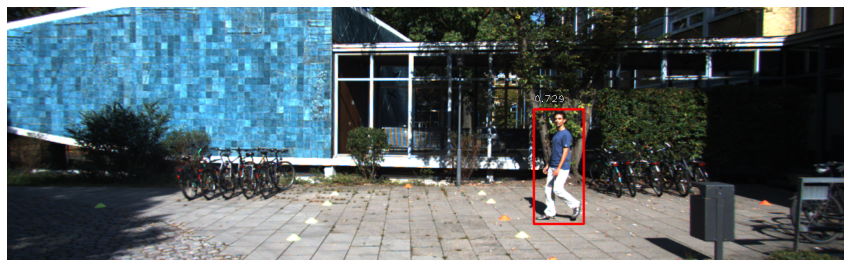

[415.36887 165.01349 499.06134 331.1634 ]
[420.55008 167.651   498.43924 323.954  ]


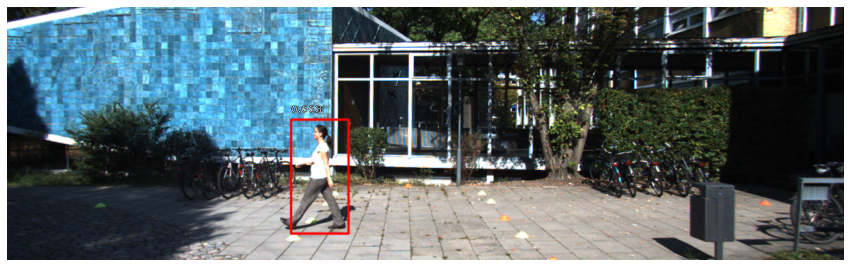

[  4.612059 200.86987  293.14758  369.12827 ]
[748.4687  161.43967 887.7194  213.28459]
[  0.      193.74664 302.47577 369.12827]


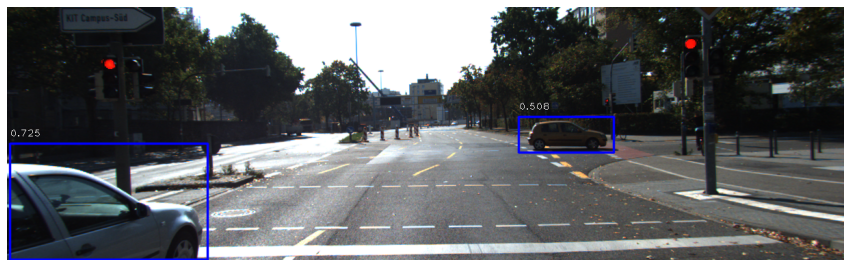

[ 727.98145    57.157585 1109.159     368.79376 ]
[ 82.117836 161.1074   366.94342  304.9599  ]


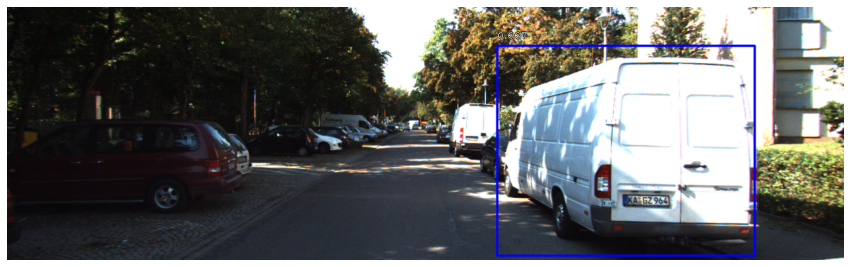

[ 870.90875  168.05487 1225.0544   373.6249 ]
[567.7974  181.276   613.2713  218.52461]


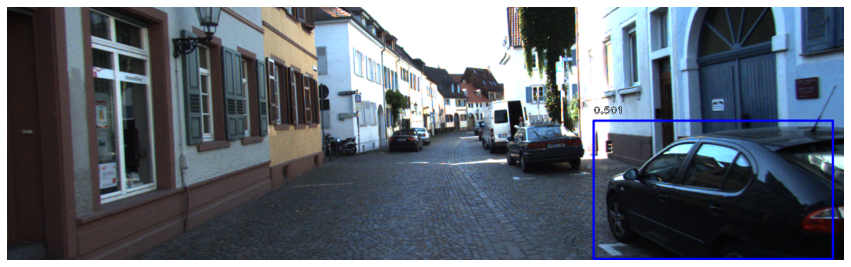

[593.62396 175.42699 625.3568  205.85602]
[198.40547 132.13652 358.19675 231.12091]


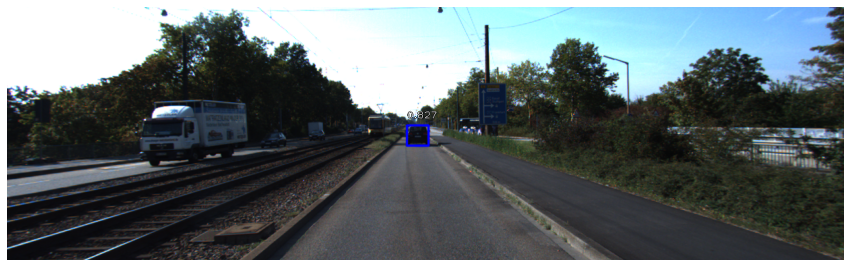

[626.48224 175.53596 664.83185 213.04398]
[516.6291  176.4421  568.0889  215.63275]


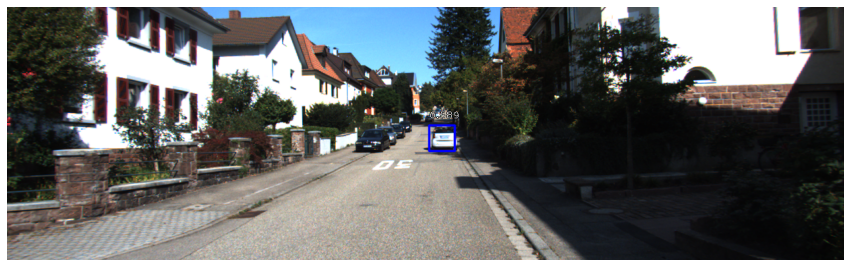

[547.75385 166.85234 574.38354 189.9731 ]


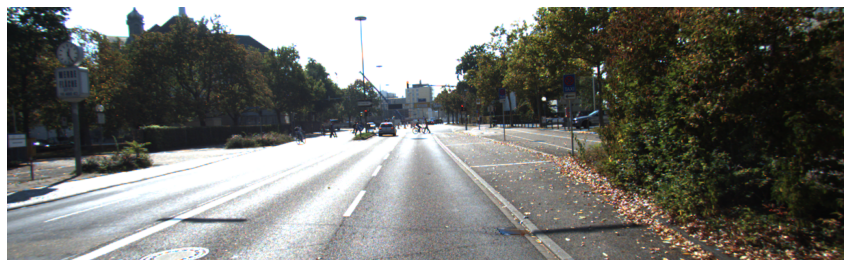

[693.26935 171.58482 791.294   251.20537]


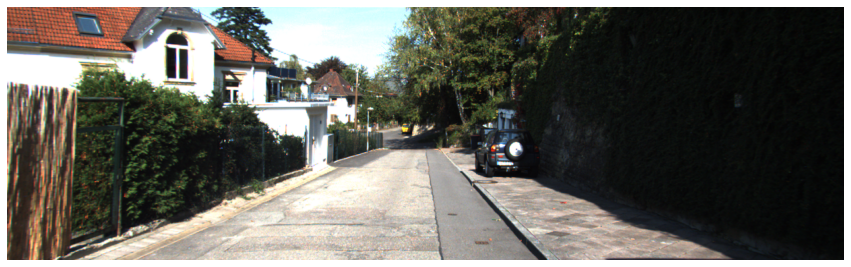

[ 13.508652 180.3181   181.69719  317.7757  ]


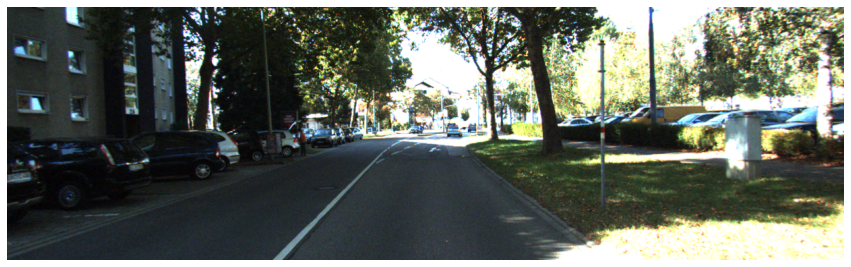

90점입니다.


In [51]:
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection'
    score = 0
    test_set=[
        ("test_set/stop_1.png", "Stop"),
        ("test_set/stop_2.png", "Stop"),
        ("test_set/stop_3.png", "Stop"),
        ("test_set/stop_4.png", "Stop"),
        ("test_set/stop_5.png", "Stop"),
        ("test_set/go_1.png", "Go"),
        ("test_set/go_2.png", "Go"),
        ("test_set/go_3.png", "Go"),
        ("test_set/go_4.png", "Go"),
        ("test_set/go_5.png", "Go"),
    ]

    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)

## 후기

-이번 노드의 데이터셋의 크기가 상당하기 때문에 데이터셋을 다운받는데 오랜 시간이 걸렸다.   
-처음 모델을 학습 시킬 때 GPU를 못 잡았는지 한 에폭 당 걸리는 시간이 10분이 넘어갔다.   
-GPU를 잡고 다시 학습을 시키니 원래의 파라미터로 학습을 시켜도 금방 학습을 시킬 수 있었다.   
-모델을 평가하니 영상에 있는 물체가 작은 경우에는 잘 포착하지 못하는 것을 확인 할 수 있다.